# AB browser test

В данном задании нужно будет:
* проанализировать АБ тест, проведённый на реальных пользователях Яндекса;
* подтвердить или опровергнуть наличие изменений в пользовательском поведении между контрольной (control) и тестовой (exp) группами;
* определить характер этих изменений и практическую значимость вводимого изменения;
* понять, какая из пользовательских групп более всего проигрывает / выигрывает от тестируемого изменения (локализовать изменение).

Описание данных:
* userID: уникальный идентификатор пользователя
* browser: браузер, который использовал userID
* slot: в каком статусе пользователь участвовал в исследовании (exp = видел измененную страницу, control = видел неизменную страницу)
* n_clicks: количество кликов, которые пользоваль совершил за n_queries
* n_queries: количество запросов, который совершил userID, пользуясь браузером browser
* n_nonclk_queries: количество запросов пользователя, в которых им не было совершено ни одного клика

Обращаем внимание, что не все люди используют только один браузер, поэтому в столбце userID есть повторяющиеся идентификаторы. В предлагаемых данных уникальным является сочетание userID и browser.

In [0]:
from __future__ import division

import numpy as np
import pandas as pd

from scipy import stats
from statsmodels.sandbox.stats.multicomp import multipletests 

%matplotlib inline
import matplotlib.pyplot as plt
import seaborn as sns

from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = "all"

In [0]:
ab_data = pd.read_csv('https://raw.githubusercontent.com/OzmundSedler/100-Days-Of-ML-Code/master/week_13/datasets/ab_browser_test.csv')

In [3]:
ab_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 566134 entries, 0 to 566133
Data columns (total 6 columns):
userID              566134 non-null int64
browser             566134 non-null object
slot                566134 non-null object
n_clicks            566134 non-null int64
n_queries           566134 non-null int64
n_nonclk_queries    566134 non-null int64
dtypes: int64(4), object(2)
memory usage: 25.9+ MB


In [4]:
ab_data.head()

,userID,browser,slot,n_clicks,n_queries,n_nonclk_queries
0,1,Browser #2,exp,23,32,19
1,3,Browser #4,exp,3,4,2
2,5,Browser #4,exp,29,35,16
3,6,Browser #4,control,12,6,0
4,7,Browser #4,exp,54,68,30


In [5]:
ab_data.describe()

,userID,n_clicks,n_queries,n_nonclk_queries
count,566134.000000,566134.000000,566134.000000,566134.000000
mean,301377.214027,11.431658,10.720524,4.703987
std,175526.333101,20.251494,16.262827,8.109958
min,1.000000,0.000000,1.000000,0.000000
25%,148627.250000,1.000000,2.000000,1.000000
50%,299362.500000,4.000000,5.000000,2.000000
75%,455698.750000,13.000000,13.000000,6.000000
max,603137.000000,863.000000,665.000000,581.000000


In [0]:
#transform 'browser' column to int
ab_data.browser = [int(ab_data.browser[i][9:]) for i in range(ab_data.shape[0])]

In [7]:
ab_data.head(10)

,userID,browser,slot,n_clicks,n_queries,n_nonclk_queries
0,1,2,exp,23,32,19
1,3,4,exp,3,4,2
2,5,4,exp,29,35,16
3,6,4,control,12,6,0
4,7,4,exp,54,68,30
5,8,4,control,4,4,1
6,9,4,exp,6,3,1
7,10,4,control,22,15,2
8,13,14,exp,2,4,3
9,15,14,control,2,2,0


Основная метрика, на которой мы сосредоточимся в этой работе, — это количество пользовательских кликов на web-странице в зависимости от тестируемого изменения этой страницы.

Посчитаем, насколько в группе exp больше пользовательских кликов по сравнению с группой control в процентах от числа кликов в контрольной группе.

In [0]:
exp_group_n_clicks = ab_data.loc[ab_data.slot == 'exp']['n_clicks']
control_group_n_clicks = ab_data.loc[ab_data.slot == 'control']['n_clicks']

In [0]:
exp_n_clicks_sum = exp_group_n_clicks.sum()
control_group_n_clicks_sum = control_group_n_clicks.sum()

In [10]:
print('Exp: %d' % exp_n_clicks_sum)
print('Control: %d' % control_group_n_clicks_sum)

Exp: 3261823
Control: 3210027


In [11]:
diff_in_percents = (exp_n_clicks_sum/control_group_n_clicks_sum - 1) * 100

print(f'Difference in percents: {diff_in_percents:.3f}%')

Difference in percents: 1.614%


Давайте попробуем посмотреть более внимательно на разницу между двумя группами (control и exp) относительно количества пользовательских кликов.

Для этого построим с помощью бутстрепа 95% доверительный интервал для средних значений и медиан количества кликов в каждой из двух групп.

In [12]:
exp_gropup_n_clicks_mean = exp_group_n_clicks.mean()
control_group_n_clicks_mean = control_group_n_clicks.mean()
print('Mean number of clicks in each group')
print('Exp: %.4f' % exp_gropup_n_clicks_mean)
print('Control: %.4f' % control_group_n_clicks_mean)

Mean number of clicks in each group
Exp: 11.5840
Control: 11.2809


In [13]:
exp_gropup_n_clicks_median = exp_group_n_clicks.median()
control_group_n_clicks_median = control_group_n_clicks.median()
print('Median number of clicks in each group')
print('Exp: %d' % exp_gropup_n_clicks_median)
print('Control: %d' % control_group_n_clicks_median)

Median number of clicks in each group
Exp: 5
Control: 4


In [0]:
def get_bootstrap_samples(data, n_samples):
    indices = np.random.randint(0, len(data), (n_samples, len(data)))
    samples = data[indices]
    return samples

In [0]:
def stat_intervals(stat, alpha):
    boundaries = np.percentile(stat, [100 * alpha / 2., 100 * (1 - alpha / 2.)])
    return boundaries

In [0]:
np.random.seed(0)

num_of_samples = 500

exp_cl_mean, exp_cl_median = np.empty(num_of_samples), np.empty(num_of_samples)
ctrl_cl_mean, ctrl_cl_median = np.empty(num_of_samples), np.empty(num_of_samples)

ctrl_cl_var = np.empty(num_of_samples)

exp_data = get_bootstrap_samples(exp_group_n_clicks.values, num_of_samples)
ctrl_data = get_bootstrap_samples(control_group_n_clicks.values, num_of_samples)

for i in range(num_of_samples):
    exp_cl_mean[i], ctrl_cl_mean[i] = exp_data[i].mean(), ctrl_data[i].mean() 
    exp_cl_median[i], ctrl_cl_median[i] = np.median(exp_data[i]), np.median(ctrl_data[i])
    
    ctrl_cl_var[i] = ctrl_data[i].var()

In [18]:
delta_mean = list(map(lambda x: x[0] - x[1], zip(exp_cl_mean, ctrl_cl_mean)))
delta_median = list(map(lambda x: x[0] - x[1], zip(exp_cl_median, ctrl_cl_median)))

delta_mean_bnd = stat_intervals(delta_mean, 0.05)
delta_median_bnd = stat_intervals(delta_median, 0.05)

print('Conf. int. delta mean: [%.4f, %.4f]' % (delta_mean_bnd[0], delta_mean_bnd[1]))
print('Conf. int. delta median: [%d, %d]' % (delta_median_bnd[0], delta_median_bnd[1]))
print('legend: diff = exp - control')

Conf. int. delta mean: [0.1996, 0.4050]
Conf. int. delta median: [1, 1]
legend: diff = exp - control


Поскольку данных достаточно много (порядка полумиллиона уникальных пользователей), отличие в несколько процентов может быть не только практически значимым, но и значимым статистически. Последнее утверждение нуждается в дополнительной проверке.

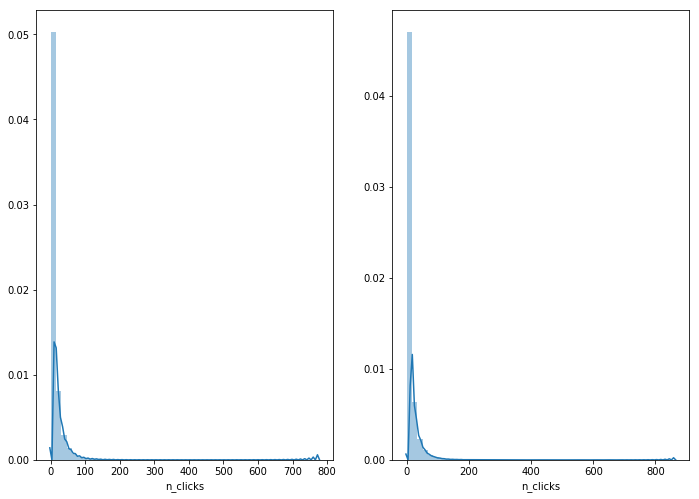

In [19]:
fig, axs = plt.subplots(ncols=2, figsize=(11.7, 8.27))
sns.distplot(exp_group_n_clicks, ax=axs[0])
sns.distplot(control_group_n_clicks, ax=axs[1])

t-критерий Стьюдента имеет множество достоинств, и потому его достаточно часто применяют в AB экспериментах. Иногда его применение может быть необоснованно из-за сильной скошенности распределения данных.

Для простоты рассмотрим одновыборочный t-критерий. Чтобы действительно предположения t-критерия выполнялись необходимо, чтобы:

* среднее значение в выборке было распределено нормально N(μ,σ2n)
* несмещенная оценка дисперсии c масштабирующим коэффициентом была распределена по хи-квадрат c n−1 степенями свободы χ2(n−1)

Оба этих предположения можно проверить с помощью бутстрепа. Ограничимся сейчас только контрольной группой, в которой распределение кликов будем называть данными в рамках данного вопроса.

Поскольку мы не знаем истинного распределения генеральной совокупности, мы можем применить бутстреп, чтобы понять, как распределены среднее значение и выборочная дисперсия.

Для этого

* получим из данных n_boot_samples псевдовыборок.
* по каждой из этих выборок посчитаем среднее и сумму квадратов отклонения от выборочного среднего
* для получившегося вектора средних значений из n_boot_samples построим q-q plot с помощью scipy.stats.probplot для нормального распределения
* для получившегося вектора сумм квадратов отклонения от выборочного среднего построим qq-plot с помощью scipy.stats.probplot для хи-квадрат распределения

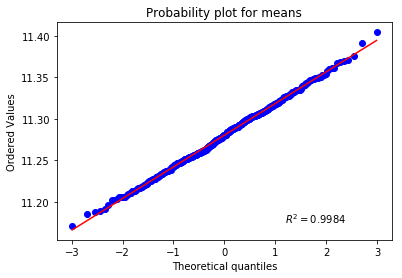

In [20]:
#probability plot for means
_ = stats.probplot(ctrl_cl_mean, plot=plt, rvalue=True)
_ = plt.title('Probability plot for means')

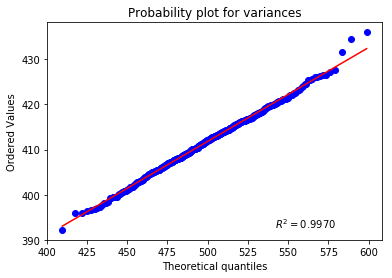

In [21]:
#probability plot for variances
_ = stats.probplot(ctrl_cl_var, plot=plt, dist='chi2', sparams=(ctrl_cl_mean.shape[0]-1), rvalue=True)
_ = plt.title('Probability plot for variances')

Одним из возможных аналогов t-критерия, которым можно воспрользоваться, является тест Манна-Уитни. На достаточно обширном классе распределений он является асимптотически более эффективным, чем t-критерий, и при этом не требует параметрических предположений о характере распределения.

Разделим выборку на две части, соответствующие control и exp группам. Преобразуем данные к виду, чтобы каждому пользователю соответствовало суммарное значение его кликов. С помощью критерия Манна-Уитни проверим гипотезу о равенстве средних.

In [22]:
users_nclicks_exp = ab_data.loc[ab_data.slot == 'exp'].groupby(['userID', 'browser']).sum().loc[:,'n_clicks']
users_nclicks_ctrl = ab_data.loc[ab_data.slot == 'control'].groupby(['userID', 'browser']).sum().loc[:,'n_clicks']

users_nclicks_exp.head()
users_nclicks_ctrl.head()

userID  browser
1       2          23
3       4           3
5       4          29
7       4          54
9       4           6
Name: n_clicks, dtype: int64

userID  browser
6       4          12
8       4           4
10      4          22
15      14          2
23      4           3
Name: n_clicks, dtype: int64

In [23]:
stats.mannwhitneyu(users_nclicks_exp, users_nclicks_ctrl, alternative='two-sided')

MannwhitneyuResult(statistic=41184125116.0, pvalue=6.247235801369629e-75)

Проверим, для какого из браузеров наиболее сильно выражено отличие между количеством кликов в контрольной и экспериментальной группах.

Для этого применим для каждого из срезов (по каждому из уникальных значений столбца browser) критерий Манна-Уитни между control и exp группами и сделаем поправку Холма-Бонферрони на множественную проверку с α=0.05.

In [24]:
browsers_nclicks_exp = ab_data.loc[ab_data.slot == 'exp'].groupby(['browser', 'userID']).sum().loc[:,'n_clicks']
browsers_nclicks_ctrl = ab_data.loc[ab_data.slot == 'control'].groupby(['browser', 'userID']).sum().loc[:,'n_clicks']

browsers_nclicks_exp.head()
browsers_nclicks_ctrl.head()

browser  userID
2        1         23
         31         7
         38        39
         41        32
         46         4
Name: n_clicks, dtype: int64

browser  userID
2        29         9
         32         3
         60         5
         70         5
         73        13
Name: n_clicks, dtype: int64

In [0]:
#Unique browsers
browsers = np.unique(ab_data.browser)
print('Unique browsers numbers: ' + str(browsers))
print('')

print('Mann-Whitney rank test without multipletest')
mw_p = np.empty(browsers.shape[0])
for i, br in enumerate(browsers):
    print('Browser #%d: ' % br),
    _, mw_p[i] = stats.mannwhitneyu(browsers_nclicks_exp.loc[br, :], browsers_nclicks_ctrl.loc[br, :], alternative='two-sided')
    print('p-value = %.4f' % mw_p[i])

print('')
print('Mann-Whitney rank test with multipletest')
_, mw_p_corr, _, _ = multipletests(mw_p, alpha = 0.05, method = 'holm')
for i, br in enumerate(browsers):
    print('Browser #%d: ' % br),
    print('p-value = %.4f' % mw_p_corr[i])

Для каждого браузера в каждой из двух групп (control и exp) посчитаем долю запросов, в которых пользователь не кликнул ни разу. Это можно сделать, поделив сумму значений n_nonclk_queries на сумму значений n_queries. Умножив это значение на 100, получим процент некликнутых запросов, который можно легче проинтерпретировать.

In [0]:
browsers_nonclk_q_exp = ab_data.loc[ab_data.slot == 'exp'].groupby(['browser']).sum().loc[:,'n_nonclk_queries']
browsers_clk_q_exp = ab_data.loc[ab_data.slot == 'exp'].groupby(['browser']).sum().loc[:,'n_queries']
browsers_nonclk_q_prop_exp = browsers_nonclk_q_exp / browsers_clk_q_exp

browsers_nonclk_q_ctrl = ab_data[ab_data.slot == 'control'].groupby(['browser']).sum().loc[:,'n_nonclk_queries']
browsers_clk_q_ctrl = ab_data[ab_data.slot == 'control'].groupby(['browser']).sum().loc[:,'n_queries']
browsers_nonclk_q_prop_ctrl = browsers_nonclk_q_ctrl / browsers_clk_q_ctrl

print('Control / experimental groups')
for br in browsers:
    print('Browser #%d' % br),
    print(browsers_nonclk_q_prop_ctrl.loc[browsers_nonclk_q_prop_ctrl.index == br].values),
    print('/'),
    print(browsers_nonclk_q_prop_exp.loc[browsers_nonclk_q_prop_ctrl.index == br].values)